# Customer shopping

## Librearías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from typing import List

%matplotlib inline
plt.style.use('ggplot')

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Funciones utiles

### Gráficas

In [3]:
def pie_plot(data: pd.DataFrame, 
             col: str,
             title: str,
             savefig: bool = False) -> None:
    """Genera un gráfico de torta basado en una columna de un DataFrame.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        col (str): El nombre de la columna a graficar.
        title: Título de la gráfica.
        savefig: Opcional. Si se quiere guardar la imagen 
         en output.

    Returns:
        None: Muestra el gráfico de pastel.

    """
    plt.figure(figsize=(8, 5))
    datos = data[col]
    labels = data.index
    
    # Se agregan colores con plt.cm estableciendo un color para cada espacio en el 
    # diagrama, por eso se usa un linspace de la misma magnitud de los datos.
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.7, len(datos)))
    
    # Generación del diagrama circular
    patches, texts = plt.pie(datos, labels=labels, colors=colors)

    # Para que siempre se vea como un círculo
    plt.axis('equal')
    
    # Se eliminan las líneas
    plt.rcParams['patch.linewidth'] = 0
    
    # Estimación porcentaje
    porcent = 100 * datos / sum(datos)
    # Lista que será expuesta en la legenda
    labels = ['{0} - {1:1.1f} %'.format(i,j) for i, j in zip(labels, porcent)]
    
    # Se genera la legenda
    # bbox_to_anchor especifica en coordenadas la posición de la legenda
    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
    
    # Agregar título
    plt.title(title)
    
    # Guardar la figura si savefig es True y se proporciona una ruta
    if savefig:
        plt.savefig(os.path.join('..', 'output', f'{title}.png'), bbox_inches='tight')
        
    plt.show()

In [4]:
def box_plot(df: pd.DataFrame,
             title: str,
             savefig: bool = False,
             showfliers: bool = True):
    """Genera un diagrama de cajas utilizando el mapa de colores RdYlGn.

    Args:
        df (pd.DataFrame): El DataFrame que se utilizará para generar 
         el diagrama de cajas.
         title: Título de la gráfica.
        savefig: Opcional. Si se quiere guardar la imagen 
         en output.
        showfliers (bool): Indica si se muestran o no los valores 
         atípicos en el diagrama de cajas. Valor predeterminado es True.

    Returns:
        None: Muestra el gráfico de barras.
        
    """
    # Generar el diagrama de cajas utilizando df.plot(kind='box')
    ax = df.plot(kind='box', patch_artist=True, figsize=(8, 5), showfliers=showfliers, vert=False)
    
    # Configurar el mapa de colores
    cmap = plt.cm.RdYlGn
    
    # Personalizar el color de las cajas utilizando el mapa de colores
    for patch, color in zip(ax.artists, cmap(np.linspace(0.1, 0.9, len(ax.artists)))):
        patch.set_facecolor(color)
        
    # Agregar título
    plt.title(title)
    
    # Guardar la figura si savefig es True y se proporciona una ruta
    if savefig:
        plt.savefig(os.path.join('..', 'output', f'{title}.png'), bbox_inches='tight')

    plt.show()

In [5]:
def bar_subplots(df: pd.DataFrame, 
                 columns: List[str],
                 title: str,
                 savefig: bool = False) -> None:
    """Genera diagramas de barras para contar la cantidad 
     según columna especificada.

    Args:
        df: DataFrame que contiene los datos de los hurtos.
        columns: Lista de columnas del DataFrame a 
         mostrar en los diagramas de barras.
        title: Título de la gráfica.
        savefig: Opcional. Si se quiere guardar la imagen 
         en output.

    """
    num_columnas = len(columns)
    num_filas = num_columnas // 2 + num_columnas % 2 

    fig, axs = plt.subplots(num_filas, 2, figsize=(12, 4 * num_filas))
    fig.tight_layout(pad=4.0)
    
    fig.suptitle(title, fontsize=16)

    for i, columna in enumerate(columns):
        ax = axs[i // 2, i % 2] if num_filas > 1 else axs[i]
        valores = df[columna].value_counts()

        ax.bar(valores.index, valores.values)
        ax.set_title(f"Transacciones {columna}")
        plt.xlabel(None)
        ax.yaxis.set_visible(False)
        
        ax.set_xticks(range(len(valores.index))) 
        ax.set_xticklabels(valores.index, rotation=20) 

        for p in ax.patches:
            ax.annotate(
                '{:,.0f}'.format(int(p.get_height())).replace(",", "."),
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10)

        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
    
    if savefig:
        plt.savefig(os.path.join('..', 'output', f'{title}.png'), bbox_inches='tight')
    plt.show()

### Limpieza

In [6]:
def find_missing(df: pd.DataFrame) -> pd.DataFrame:
    """Encuentra los valores faltantes en un DataFrame y devuelve un nuevo DataFrame
     que muestra la cantidad de valores faltantes y el porcentaje correspondiente.

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame que muestra las columnas, la cantidad de
        valores faltantes y el porcentaje de valores faltantes para cada columna.

    """
    lista = []
    for col in df.columns:
        num = df[df[col].isnull()].shape[0]
        lista.append(num)
    
    dic = {
        'Columnas': df.columns,
        'Faltantes': lista}
    df_faltantes = pd.DataFrame(dic)
    
    df_faltantes['Porcentaje'] = df_faltantes['Faltantes'] / df.shape[0]
    
    return df_faltantes

# Exploración de datos

## Carga de datos

In [7]:
path = os.path.join('..', 'data', 'customer_shopping_data.csv')
shopping_data = pd.read_csv(path)

In [8]:
shopping_data.head(2)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul


In [9]:
shopping_data.shape

(99457, 10)

In [10]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [11]:
shopping_data.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


## Visualización de características

In [12]:
# Se realiza la separación de las columnas categoricas y numéricas para realizar la imputación de datos
shopping_categorical = shopping_data.select_dtypes(include=['object'])
shopping_numeric = shopping_data.select_dtypes(include=[np.number])

### Características categóricas

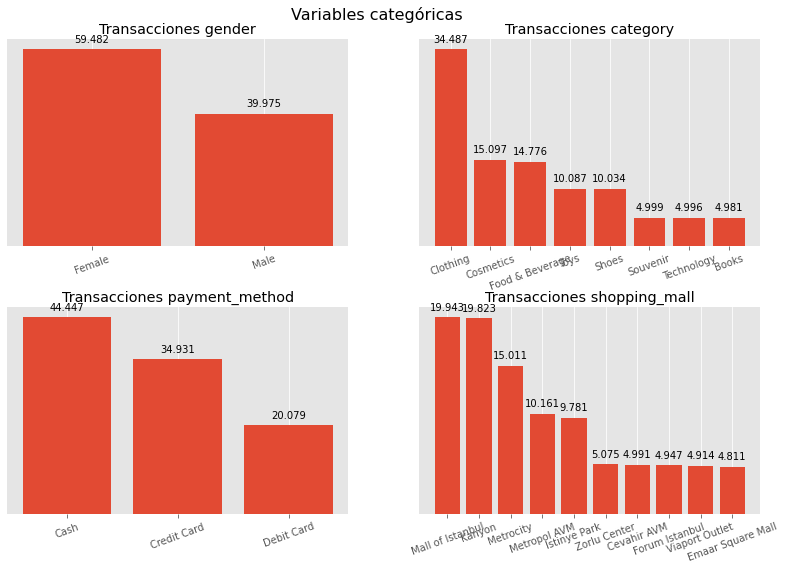

In [13]:
cols = ['gender', 'category', 'payment_method', 'shopping_mall']

bar_subplots(
    df=shopping_categorical, 
    columns=cols, 
    title='Variables categóricas', 
    savefig=True)

In [14]:
gender = shopping_data.groupby('gender').agg({'customer_id': 'count'})

In [15]:
gender

,customer_id
gender,
Female,59482
Male,39975


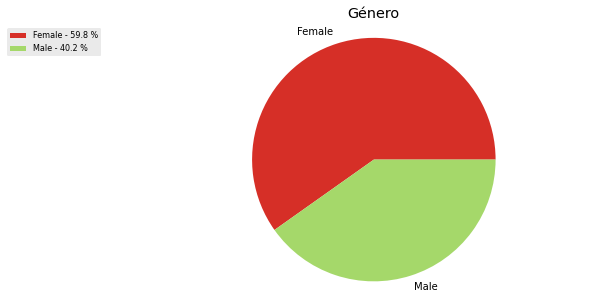

In [16]:
pie_plot(
    data=gender, 
    col='customer_id',
    title='Género',
    savefig=True)

* En la gráfica anterior se evidencia que son las mujeres las que tienen una mayor participación en las compras con una diferencia de $19.507$ transacciones de diferencia.

In [17]:
payment_method = shopping_data.groupby('payment_method').agg({'customer_id': 'count'})

In [18]:
payment_method

,customer_id
payment_method,
Cash,44447
Credit Card,34931
Debit Card,20079


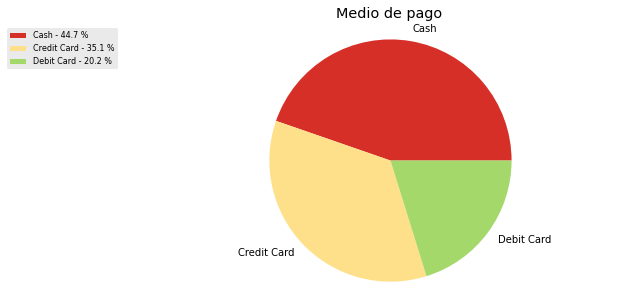

In [19]:
pie_plot(
    data=payment_method, 
    col='customer_id',
    title='Medio de pago',
    savefig=True)

* La mayoría de las compras registradas en el data set se realizan con efectivo, teniendo una participación del 44.75%, seguido de las tarjetas crédito y débito con 35.1% y 20.2% respectivamente.

In [20]:
shopping_mall = shopping_data.groupby('shopping_mall').agg({'customer_id': 'count'})

In [21]:
shopping_mall

,customer_id
shopping_mall,
Cevahir AVM,4991
Emaar Square Mall,4811
Forum Istanbul,4947
Istinye Park,9781
Kanyon,19823
Mall of Istanbul,19943
Metrocity,15011
Metropol AVM,10161
Viaport Outlet,4914


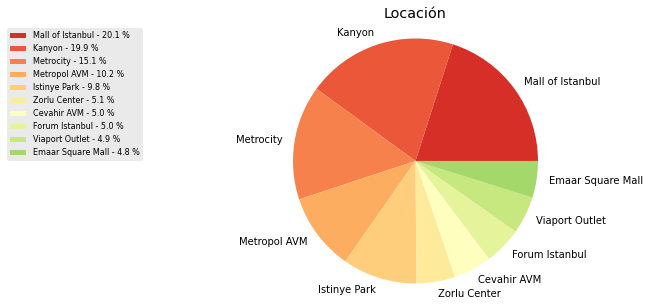

In [22]:
pie_plot(
    data=shopping_mall.sort_values('customer_id', ascending=False), 
    col='customer_id',
    title='Locación',
    savefig=True)

In [23]:
category = shopping_data.groupby('category').agg({'customer_id': 'count'})

In [24]:
category

,customer_id
category,
Books,4981
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Shoes,10034
Souvenir,4999
Technology,4996
Toys,10087


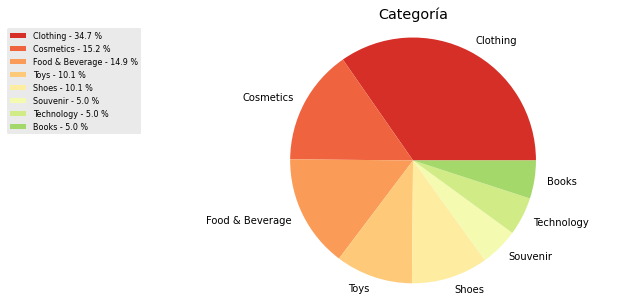

In [25]:
pie_plot(
    data=category.sort_values('customer_id', ascending=False), 
    col='customer_id',
    title='Categoría',
    savefig=True)

### Características numéricas

* Se seleccionan las columnas numéricas para escalar y tener un diagrama de cajas con las caracteríscas en la misma escala

In [26]:
shopping_numeric.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


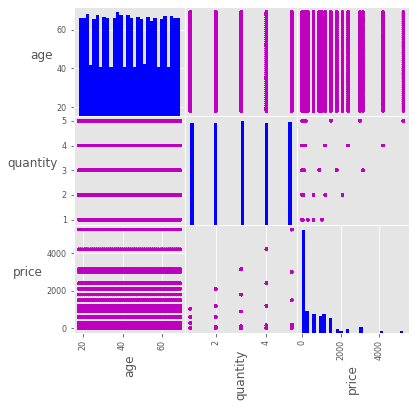

In [27]:
axes = pd.plotting.scatter_matrix(
    shopping_numeric,
    alpha=0.7,
    figsize=(6, 6),
    range_padding=0.1,
    diagonal='hist',
    color='m',
    hist_kwds={
        'bins': 30, 
        'color': 'blue'
    }
)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

## Imputación de datos

In [28]:
missing_values = find_missing(shopping_data)

In [29]:
missing_values

,Columnas,Faltantes,Porcentaje
0,invoice_no,0,0.0
1,customer_id,0,0.0
2,gender,0,0.0
3,age,0,0.0
4,category,0,0.0
5,quantity,0,0.0
6,price,0,0.0
7,payment_method,0,0.0
8,invoice_date,0,0.0
9,shopping_mall,0,0.0


## Datos atípicos

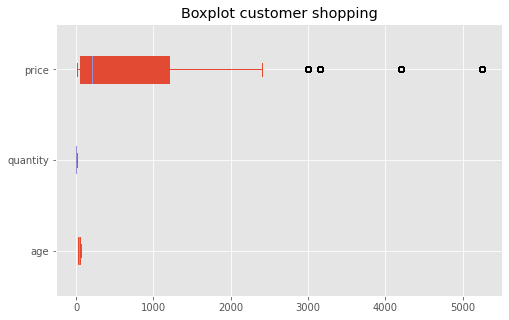

In [30]:
box_plot(
    df=shopping_numeric,
    title='Boxplot customer shopping',
    savefig=True)

In [31]:
# Normalización de los datos
min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(shopping_numeric)

numeric_scale = pd.DataFrame(numeric_scale, columns=shopping_numeric.columns)

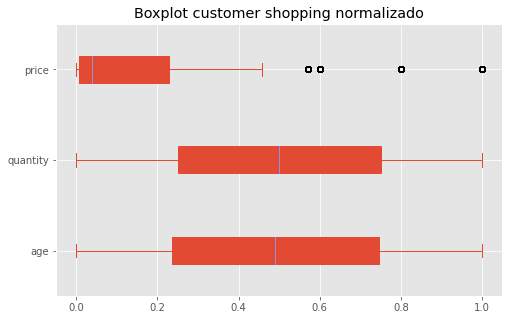

In [32]:
box_plot(
    df=numeric_scale,
    title='Boxplot customer shopping normalizado',
    savefig=True)

## Detección de outliers con el algoritmo LOF

In [33]:
lof = LocalOutlierFactor(
    n_neighbors=3, 
    algorithm='auto', 
    contamination='auto', 
    metric='euclidean')

In [34]:
lof_array = lof.fit_predict(numeric_scale)

In [35]:
ground_truth = np.ones(len(numeric_scale), dtype=int)

In [36]:
n_errors = (lof_array != ground_truth).sum()

In [37]:
n_errors

0

Bajo el algoritmo LOF no se encontraron datos atípicos por lo que no hay necesidad de realizar imputación de datos.

# Análisis estadístico

In [38]:
cols = ['gender', 'payment_method', 'shopping_mall']
shopping_categorical = shopping_categorical[cols]

## Variables categóricas

### Tablas de contingencia

Una tabla de contingencia, es una herramienta estadística que se utiliza para resumir y analizar la relación entre dos o más variables categóricas. En una tabla de contingencia, se registran las frecuencias conjuntas de las categorías de las variables categóricas, lo que permite visualizar y analizar patrones de asociación o independencia entre ellas.

In [39]:
gender_payment = pd.crosstab(
    index=shopping_categorical['gender'],
    columns=shopping_categorical['payment_method'],
    margins=True,
    margins_name="Total")

gender_payment

payment_method,Cash,Credit Card,Debit Card,Total
gender,,,,
Female,26509,21011,11962,59482
Male,17938,13920,8117,39975
Total,44447,34931,20079,99457


In [40]:
gender_mall = pd.crosstab(
    index=shopping_categorical['gender'],
    columns=shopping_categorical['shopping_mall'],
    margins=True,
    margins_name="Total")

gender_mall

shopping_mall,Cevahir AVM,Emaar Square Mall,Forum Istanbul,Istinye Park,Kanyon,Mall of Istanbul,Metrocity,Metropol AVM,Viaport Outlet,Zorlu Center,Total
gender,,,,,,,,,,,
Female,2940,2842,3016,5874,11906,11902,8941,6144,2949,2968,59482
Male,2051,1969,1931,3907,7917,8041,6070,4017,1965,2107,39975
Total,4991,4811,4947,9781,19823,19943,15011,10161,4914,5075,99457


In [41]:
payment_mall = pd.crosstab(
    index=shopping_categorical['payment_method'],
    columns=shopping_categorical['shopping_mall'],
    margins=True,
    margins_name="Total")

payment_mall

shopping_mall,Cevahir AVM,Emaar Square Mall,Forum Istanbul,Istinye Park,Kanyon,Mall of Istanbul,Metrocity,Metropol AVM,Viaport Outlet,Zorlu Center,Total
payment_method,,,,,,,,,,,
Cash,2228,2114,2183,4436,8853,8894,6625,4559,2231,2324,44447
Credit Card,1779,1696,1750,3422,6916,7019,5347,3521,1721,1760,34931
Debit Card,984,1001,1014,1923,4054,4030,3039,2081,962,991,20079
Total,4991,4811,4947,9781,19823,19943,15011,10161,4914,5075,99457


### Test Chi-Cuadrado

El test de chi-cuadrado, es una prueba estadística que se utiliza para determinar si existe una asociación significativa entre dos variables categóricas en una tabla de contingencia. El objetivo principal del test de chi-cuadrado es evaluar si las dos variables son independientes o si existe una relación significativa entre ellas.

In [42]:
chi2, p, _, _ = chi2_contingency(gender_payment)

print('Estadístico Chi-cuadrado:', chi2)
print('Valor p:', p)

# Determina si rechazar o no la hipótesis nula
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print('Se rechaza la hipótesis nula:'
          'Hay una relación significativa entre gender y payment_method.')
else:
    print('No se rechaza la hipótesis nula:'
          'No hay evidencia suficiente para concluir una relación significativa.')

Estadístico Chi-cuadrado: 2.66502007287277
Valor p: 0.8495614219432935
No se rechaza la hipótesis nula:No hay evidencia suficiente para concluir una relación significativa.


Como el valor p (0.85) es mayor que un nivel de significancia predefinido (generalmente 0.05), no tenemos evidencia suficiente para concluir que hay una relación significativa entre el género y el método de pago.
En otras palabras, no podemos decir con confianza que el género de las personas está relacionado de manera significativa con el método de pago que eligen.

In [43]:
chi2, p, _, _ = chi2_contingency(gender_mall)

print('Estadístico Chi-cuadrado:', chi2)
print('Valor p:', p)

# Determina si rechazar o no la hipótesis nula
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print('Se rechaza la hipótesis nula:'
          'Hay una relación significativa entre gender y shopping_mall.')
else:
    print('No se rechaza la hipótesis nula:'
          'No hay evidencia suficiente para concluir una relación significativa.')

Estadístico Chi-cuadrado: 12.446589184688174
Valor p: 0.8998478278721687
No se rechaza la hipótesis nula:No hay evidencia suficiente para concluir una relación significativa.


In [44]:
chi2, p, _, _ = chi2_contingency(payment_mall)

print('Estadístico Chi-cuadrado:', chi2)
print('Valor p:', p)

# Determina si rechazar o no la hipótesis nula
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print('Se rechaza la hipótesis nula:'
          'Hay una relación significativa entre payment_method y shopping_mall.')
else:
    print('No se rechaza la hipótesis nula:'
          'No hay evidencia suficiente para concluir una relación significativa.')

Estadístico Chi-cuadrado: 14.086052029704614
Valor p: 0.9939709287574926
No se rechaza la hipótesis nula:No hay evidencia suficiente para concluir una relación significativa.


### Matriz de Información Mutua

La Matriz de Información Mutua (MIM), es una herramienta utilizada en el campo de la estadística y el análisis de datos para medir la relación o la dependencia entre dos o más variables aleatorias, especialmente en el contexto de variables discretas o categóricas. La Información Mutua (MI) es una medida que cuantifica la dependencia entre dos variables aleatorias al medir cuánta información proporciona una variable sobre la otra.

In [45]:
datos_array = shopping_categorical.values
features = np.arange(0, datos_array.shape[1])
MI = []

for d in features:
    for e in features:
        Tabla_Contingencia = pd.crosstab(datos_array[:,d], datos_array[:,e])
        mi = mutual_info_score(labels_true=None, labels_pred=None, contingency = Tabla_Contingencia)
        MI.append(mi)

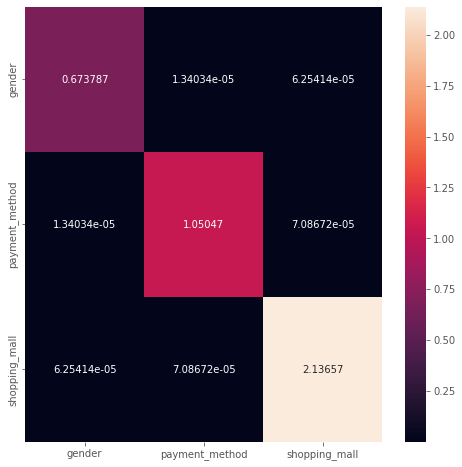

In [46]:
MI = np.asarray(MI)
MI = MI.reshape(datos_array.shape[1], datos_array.shape[1])

plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    MI, 
    annot=True, 
    fmt='g', 
    xticklabels = shopping_categorical.columns,
    yticklabels = shopping_categorical.columns)
plt.show()

Los valores de infomración mutua son muy pequeños por lo que podemos concluir que las variables categóricas no están relacionadas.

## Variables numéricas

### Coeficiente de Correlación de Pearson

In [47]:
r = []
valor_p = []

data = shopping_numeric.values
caracteristicas = shopping_numeric.columns
data = np.asarray(data)

for _, n in enumerate(np.arange(0, data.shape[1])):
    for _, m in enumerate(np.arange(0, data.shape[1])):
        r_valor, p_valor = pearsonr(data[:, n], data[:, m])
        r.append(r_valor)
        valor_p.append(p_valor)

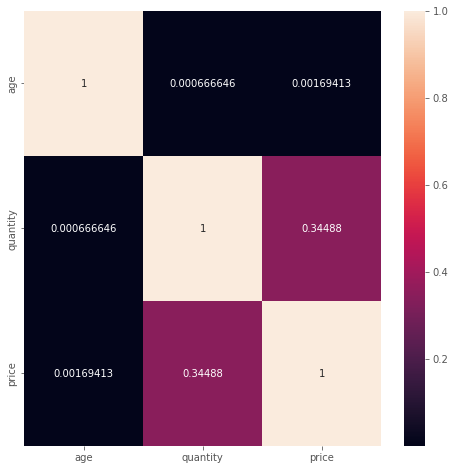

In [48]:
r = np.asarray(r)
valor_p = np.asarray(valor_p)

# Reshape de los arreglos para coincidir con las dimensiones de los datos originales
pearson_r = r.reshape(data.shape[1], data.shape[1])
p_value = valor_p.reshape(data.shape[1], data.shape[1])

# Creación de un gráfico de mapa de calor
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    pearson_r, 
    annot=True, 
    fmt='g', 
    xticklabels=caracteristicas, 
    yticklabels=caracteristicas)

plt.show()

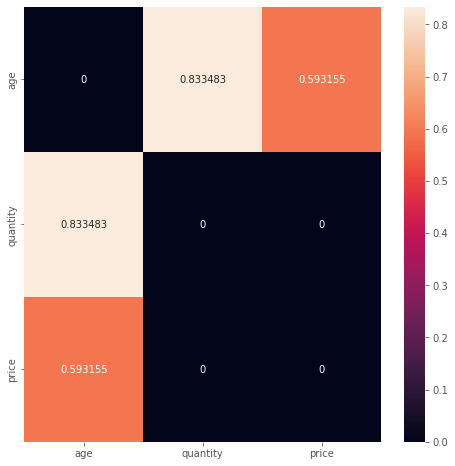

In [49]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    p_value, 
    annot=True, 
    fmt='g', 
    xticklabels=caracteristicas, 
    yticklabels=caracteristicas)

plt.show()

Si $ \rho <= 0.05 $, la correlación es estadísticamente significativo lo cual hay una relación lineal entre las dos características o variables.
Si $ \rho > 0.05 $, la correlación no es estadísticamente significativo lo cual no hay una correlación lineal significativa entre las dos características o variables.

Por lo tanto, $price$ y $quantity$ estan correlacionadas linealmente.

# Transformaciones

In [50]:
shopping_categorical_dummy = pd.get_dummies(shopping_categorical, drop_first=True)

In [51]:
shopping_categorical_dummy.head()

,gender_Male,payment_method_Credit Card,payment_method_Debit Card,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,0,1,0,0,0,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0


In [52]:
shopping_data['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: category, dtype: int64

In [53]:
categories_shopping = shopping_data.groupby('category').agg({'customer_id': 'count'})

In [54]:
categories_shopping

,customer_id
category,
Books,4981
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Shoes,10034
Souvenir,4999
Technology,4996
Toys,10087


In [55]:
categories_shopping['per'] = categories_shopping['customer_id'] / categories_shopping['customer_id'].sum() * 100

In [56]:
categories_shopping = categories_shopping.sort_values(by='customer_id', ascending=False)

In [57]:
categories_shopping

,customer_id,per
category,,
Clothing,34487,34.675287
Cosmetics,15097,15.179424
Food & Beverage,14776,14.856672
Toys,10087,10.142071
Shoes,10034,10.088782
Souvenir,4999,5.026293
Technology,4996,5.023276
Books,4981,5.008194


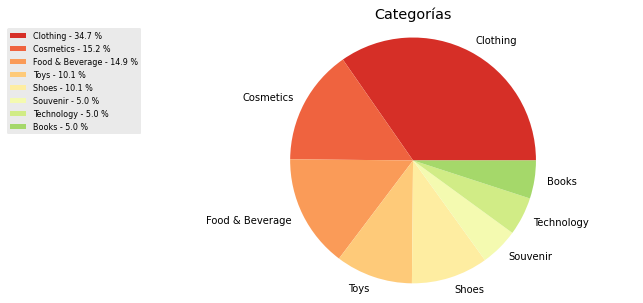

In [58]:
pie_plot(
    data=categories_shopping, 
    col='customer_id',
    title='Categorías',
    savefig=True)

## Agrupación de categorias de bajo porcentaje de participación

* Eliminar la columna Technology porque no aporta suficientes datos al modelo.

In [59]:
cond = shopping_data['category'] != 'Technology'
shopping_data = shopping_data[cond]

In [60]:
cats = ['Souvenir', 'Books']

for cat in cats:
    cond = shopping_data['category'] == cat
    shopping_data.loc[cond, 'category'] = 'Other'

In [61]:
categories_shopping = shopping_data.groupby('category').agg({'customer_id': 'count'})

In [62]:
categories_shopping

,customer_id
category,
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Other,9980
Shoes,10034
Toys,10087


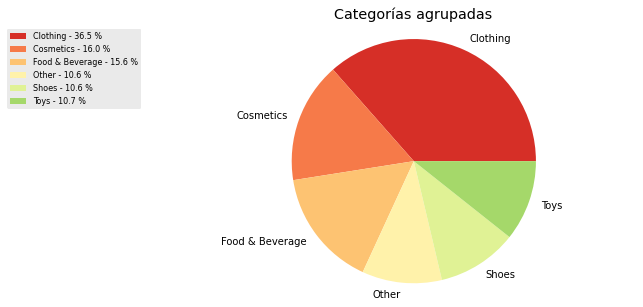

In [63]:
pie_plot(
    data=categories_shopping, 
    col='customer_id',
    title='Categorías agrupadas',
    savefig=True)

## Creación de nuevas columnas

In [64]:
shopping_data.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [65]:
columns = ['age', 'category', 'price']

In [66]:
data_set = shopping_data[columns]

In [67]:
data_set = pd.concat([data_set, shopping_categorical_dummy], axis=1)

In [68]:
data_set.head()

,age,category,price,gender_Male,payment_method_Credit Card,payment_method_Debit Card,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,28.0,Clothing,1500.40,0,1,0,0,0,0,1,0,0,0,0,0
1,21.0,Shoes,1800.51,1,0,1,0,1,0,0,0,0,0,0,0
2,20.0,Clothing,300.08,1,0,0,0,0,0,0,0,1,0,0,0
3,66.0,Shoes,3000.85,0,1,0,0,0,0,0,0,0,1,0,0
4,53.0,Other,60.60,0,0,0,0,0,0,1,0,0,0,0,0


In [69]:
path_save = os.path.join('..', 'data', 'customers_model.csv')
data_set.to_csv(path_save, index=False)